In [1]:
import pandas as pd

import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
# from HH_tools import *
import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

from IPython.display import display, HTML

In [2]:
print(pd.__version__)
print(gpd.__version__)
import matplotlib
print(matplotlib.__version__)

# python 3
# 0.24.2
# 0.4.0
# 3.0.3

# python 2 
# 0.23.4
# 0.3.0
# 2.2.4

0.23.4
0.3.0
2.2.4


In [3]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!

path = './data/disagg_struct_refs/sources/US/'
# agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['total_annual_wages', 'Wages'],
                                 ['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [23]:
# variable = 'annual_avg_emplvl'
variable = 'annual_avg_estabs'
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

#### Other Variables

# Population
county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)
county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

# Wages
df_indu = df_cnt.groupby(level = 0).sum()
avg_wages_city = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_city = avg_wages_city.rename(columns= {'total_annual_wages': 'avg_annual_wages'})
# avg_wages_city = np.log10(avg_wages_city)
avg_wages_city.index = avg_wages_city.index.astype(str).str.zfill(5)

# Area
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

In [24]:
X_vars = pd.concat([county_pop.loc[X.index], avg_wages_city.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X = pd.concat([X_vars, X], axis = 1, sort = True)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [25]:
def cosine_similarity(table):
#     vals = table.values
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
#     return pd.DataFrame(result, columns = table.columns, index = table.index)
    return result

def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

## Debug  y Exploracion scatterplots directos.

In [26]:
X_ = X # save copy fopr future, eg cosine similarity

In [27]:
fillzero = .1
X = X.T.fillna(X.min(1)).T.replace(0, fillzero)

In [28]:
corr = np.log10(X).corr(min_periods = 30).fillna(0) 
#RuntimeWarning: divide by zero encountered in log10
df = corr
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_corr_vals = corr.stack()[~keep]


cos = cosine_similarity(X_.fillna(0))
#RuntimeWarning: divide by zero encountered in log10
df = cos
keep = np.triu(np.ones(df.shape)).astype('bool').reshape(df.size) # mask upper triangular, que la negaremos
undirected_cos_vals = cos.stack()[~keep]

In [32]:

# pares = pd.DataFrame(undirected_cos_vals.sort_values().sample(40).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_corr_vals.sort_values().head(10).sort_values(), columns = ['corr'])
# # pares = pd.DataFrame(undirected_cos_vals.sort_values().head(10).sort_values(), columns = ['cos'])
# display(pares)

# for i, row in pares.iterrows():
#     display(industry_titles.loc[industry_titles.industry_code.isin(list(i))])
#     print('cos: '+str(undirected_cos_vals[i]))
#     print('corr: '+str(undirected_corr_vals[i]))
    
#     fig, axs = plt.subplots(1, 2, figsize = (14, 5))

#     colx = i[0]; coly = i[1]

#     ax = axs[0]
#     X.plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = X[list(i)]
# #     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != fillzero) & (fit_data_df[i[1]] != fillzero)].values
#     fit_data = fit_data_df.values
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--')
#     ax.set_xlim(-10, 100); ax.set_ylim(-10, 100)

#     ax = axs[1]
#     np.log10(X).plot.scatter(colx, coly, s=None, c=None, alpha = .2, ax = ax)
#     fit_data_df = np.log10(X)[list(i)]
#     fit_data = fit_data_df.loc[(fit_data_df[i[0]] != np.log10(fillzero)) & (fit_data_df[i[1]] != np.log10(fillzero))].values
    
#     z = np.polyfit(fit_data[:, 0], fit_data[:, 1], 1)
#     p = np.poly1d(z); print(p)
#     ax.plot(sorted(fit_data[:, 0]), p(sorted(fit_data[:, 0])), '--', c = 'r')

#     plt.show()


### Debug para communities

Repetimos el clustering muchas veces y tomamos 'cores' de actividades que siempre estan juntas.

In [124]:
from sklearn.cluster import SpectralClustering

# adjacencyM = demean(np.log10(X.replace(0, .04)).corr(min_periods = 30)) #RuntimeWarning: divide by zero encountered in log10
# adjacencyM = cosine_similarity(X_.fillna(0))
adjacencyM = np.log10(X).corr(min_periods = 30).fillna(0) #RuntimeWarning: divide by zero encountered in log10


clust_result_list = []
n = 10
for i in range(n):
    clustering = SpectralClustering(n_clusters=10,
            assign_labels="discretize", random_state = i).fit(adjacencyM.values)

    clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])

    clust_result_list += [clust_result]
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])
# clust_result.index.name = 'industry_code'

# clust_result['link'] = True
# clust_result = clust_result.reset_index().set_index(['industry_code', 'cluster'])

pd.concat(clust_result_list, axis = 1).head()

,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster,cluster
POPESTIMATE2010,5,0,0,0,0,0,0,0,5,4
total_annual_wages,1,1,5,1,1,1,6,1,2,2
ALAND,3,3,1,3,9,6,1,3,7,3
1114,6,4,9,4,5,4,3,2,9,9
1119,3,6,4,3,4,3,8,8,4,6


In [125]:
clust_compare_table = pd.concat(clust_result_list, axis = 1)
clust_compare_table.columns = range(clust_compare_table.shape[1])
patterns_ranking = clust_compare_table.groupby(range(n)).size().sort_values(ascending = False)
patterns_ranking.head(15)
# clust_compare_table.drop_duplicates().sort_values([0, 1, 2])

# display debugs
# clust_compare_table.sort_values(range(n)).reset_index().merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'left')
# count = clust_compare_table.groupby(range(n)).size()
# pd.DataFrame(count[count < 2], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n)).merge(industry_titles, left_on = 'index', right_on = 'industry_code')

0  1  2  3  4  5  6  7  8  9
5  0  0  0  0  0  0  0  5  4    84
1  1  5  1  1  1  6  1  2  2    71
4  5  8  7  6  5  9  6  3  0    55
6  4  9  4  5  4  3  2  9  9    31
2  8  2  5  2  9  2  5  1  8    29
6  4  9  4  5  4  3  2  9  8    9 
7  2  3  2  8  6  7  4  0  3    7 
9  7  6  8  3  2  5  7  6  5    5 
3  3  1  3  9  3  1  3  7  5    4 
2  8  6  6  3  9  5  5  1  1    3 
0  9  7  9  7  3  4  8  8  7    3 
   7  6  6  3  2  5  8  6  1    3 
9  7  6  8  3  2  5  7  6  1    2 
3  3  1  3  9  2  1  3  7  5    2 
   6  4  6  4  3  8  8  4  6    2 
dtype: int64

In [126]:
count = clust_compare_table.groupby(range(n)).size()
clust_result = pd.DataFrame(count[count > 5], columns = ['#_indus']).reset_index().merge(clust_compare_table.reset_index(), on = range(n))
clust_result['cluster'] = clust_result[range(n)].astype(str).sum(1)
clust_result['cluster'] = clust_result.cluster.rank(method = 'dense')

indu_names = industry_titles.loc[industry_titles.industry_code.isin(X.columns)]
clust_result = clust_result.merge(indu_names, left_on = 'index', right_on = 'industry_code', how = 'right')
# clust_result = clust_result.set_index()
clust_result = clust_result.set_index('industry_code')[['cluster', 'industry_title']]
clust_result['cluster'] = clust_result['cluster'].fillna(0).astype(int)
clust_result = clust_result.sort_index()
clust_result.head()

,cluster,industry_title
industry_code,,
1111,7,NAICS 1111 Oilseed and grain farming
1112,0,NAICS 1112 Vegetable and melon farming
1113,0,NAICS 1113 Fruit and tree nut farming
1114,6,NAICS 1114 Greenhouse and nursery production
1119,0,NAICS 1119 Other crop farming


In [88]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = -1

In [43]:
# # Try spectral clustering. Works when matrix is demeaned
# from sklearn.cluster import SpectralClustering

# # adjacencyM = demean(np.log10(X.replace(0, .04)).corr(min_periods = 30)) #RuntimeWarning: divide by zero encountered in log10
# # adjacencyM = adjacencyM.fillna(adjacencyM.mean())
# # adjacencyM = demean(cosine_similarity(X.fillna(0)))
# # adjacencyM = cosine_similarity(X.fillna(0))
# # adjacencyM = np.log10(X.replace(0, .04)).corr(min_periods = 30) #RuntimeWarning: divide by zero encountered in log10

# clustering = SpectralClustering(n_clusters=10, affinity = 'precomputed',
#         assign_labels="discretize", random_state=0).fit(adjacencyM.values)

# pd.options.display.max_rows = 500
# clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
# clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

# clust_result.index.name = 'industry_code'

In [ ]:
# UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
# FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

### Debug para parametros de trimeo de network. 

Se recomienda q=.95 y no hace falta max_d.

In [127]:
similarity_colname = 'similarity'
weight_column = similarity_colname

adjacencyM = demean(cosine_similarity(X.fillna(0)))

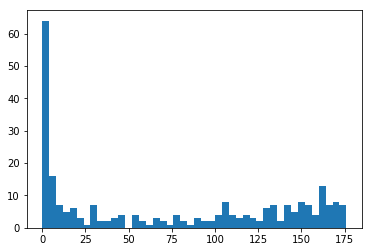

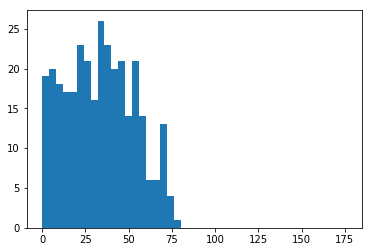

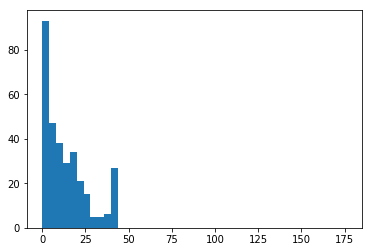

In [128]:
def plot_degree_dist(G, bins = 20):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins)
    plt.show()
    
# not demeaned
# Cosine sin demeaning. Th at q = .7
edges = pd.DataFrame(cosine_similarity(X.fillna(0)).stack(), columns = [similarity_colname])
edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.7)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

G1 = nx.from_pandas_edgelist(edges_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G1, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9
#demeaned. btw this is the adjancency for cluistering
edges0 = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges0_s = edges0.loc[edges0[similarity_colname] > edges0[similarity_colname].quantile(.9)]
edges0_s.index.names = ['industry_code_x', 'industry_code_y']

G0 = nx.from_pandas_edgelist(edges0_s.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G0, np.arange(0, 180, 4))

# Demeaned cosine. Th at q=.9, added MAX degree
max_d = 40
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

G2 = nx.from_pandas_edgelist(edges_max_d.reset_index(), 'industry_code_x', 'industry_code_y', weight_column)
plot_degree_dist(G2, np.arange(0, 180, 4))

In [129]:
##############################
# For the networkX plot 
##############################

edges = pd.DataFrame(adjacencyM.stack(), columns = [similarity_colname])
edges_s = edges.loc[edges[similarity_colname] > edges[similarity_colname].quantile(.9)]

edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s[similarity_colname] = edges_s[similarity_colname].astype(float)

# ### Max degree = max_d. Parameter used to trim the network.
# max_d = 40
# df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
# edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)


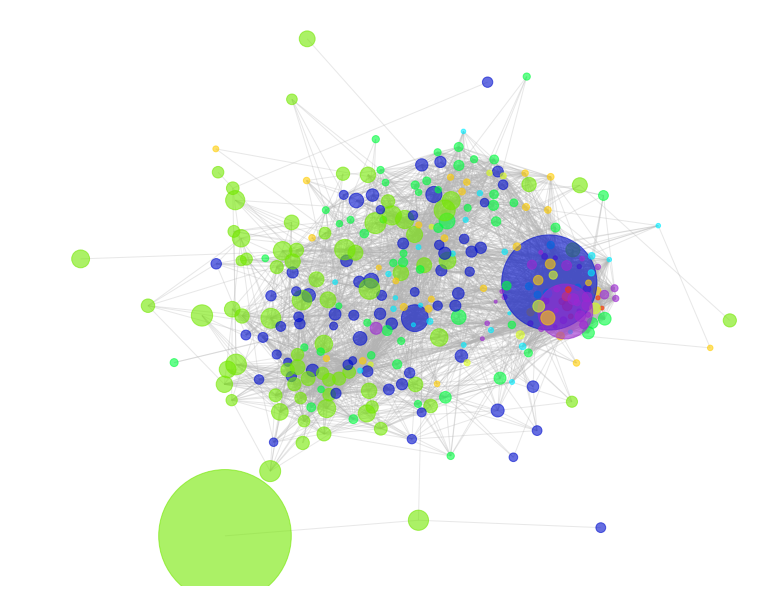

In [130]:

import matplotlib.colors as mcolors
import networkx as nx

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))
nodes['color'] = nodes['color'].replace('#000080', '#9c28d2')

import json

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_s, 'industry_code_x', 'industry_code_y', weight_column)
# G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)

plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]

## POSITIONS. Compute VS Load file
pos = nx.spring_layout(G, k=.4)

# f = open("./data/node_layout","w")
# f.write(json.dumps(pos, default=default))

# f = open('./data/node_layout', 'r')
# pos = json.loads(f.read())

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.show()

In [131]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T

nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'cluster', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]
nodes_['presence'] = True

nodes_.loc[nodes_.cluster == 0, 'color'] = 'd3d3d3' # Light gray, because cluster 0 would mean no cluster


## Wages and MFG-services color schemes
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg
conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]
choices = ['#000080', '#ffc400', '#00b0ff', '#FF0000']
nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


def color_from_series(df, ix_col, val_col, cmap = plt.cm.coolwarm):
    import matplotlib.colors as mcolors

    # create color reference
    qlo = df[val_col].quantile(.2)
    qhi = df[val_col].quantile(.8)
    norm = mcolors.Normalize(vmin=qlo, vmax=qhi, clip=True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap=cmap)
    df['color'] = df[val_col].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x))) 
    color = df[[ix_col, 'color']]
    return color

df_city = df_cnt.groupby(level = 1).sum()
avg_wages_indu = df_city[['total_annual_wages']].div(df_city[['annual_avg_emplvl']].values).dropna()
avg_wages_indu = np.log10(avg_wages_indu)
avg_wages_indu = avg_wages_indu.reset_index()
avg_wages_indu['industry_code'] = avg_wages_indu['industry_code'].astype(str)

wages_color = color_from_series(avg_wages_indu, 'industry_code', 'total_annual_wages', 
                                cmap = plt.cm.RdYlGn).rename(columns = {'color': 'wage_color'})

In [132]:
nodes_ = nodes_.merge(wages_color, how = 'left', left_on = 'id', right_on = 'industry_code')

In [133]:

##############################
# For the interactive network 
##############################

edges_df = edges_s # edges_max_d

edges_df['edge_tuple'] = list(zip(edges_df.industry_code_x, edges_df.industry_code_y))
edges_df['edge_tuple_rev'] = list(zip(edges_df.industry_code_y, edges_df.industry_code_x))
edges_triangles = edges_df.loc[edges_df.edge_tuple.isin(G.edges()) | edges_df.edge_tuple_rev.isin(G.edges())]

links = edges_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

In [134]:
network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [135]:
# nodes_

In [ ]:
name = 'wages'; color = 'wage_color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

In [ ]:
name = 'anchors'; color = 'color_mfg_srv';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

In [136]:
name = 'clusters'; color = 'color';

ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color=color,
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")

ps.draw(nodes_)
name = name
visualization_html = ps.dump_html(nodes_)
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

## Save partial results

In [ ]:
nodes.head()

In [ ]:
# nodes.loc[nodes.cluster == int(col)].sort_values('industry_code')

In [ ]:
nodes.reset_index().rename(columns = {'index': 'industry_code'}).to_csv('./../data/naics_cluster_color.csv')

## Colored Counties

In [ ]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)] # Drop the unclassified!
X = df_cnt.unstack()[variable]

X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

In [ ]:
nodes = pd.read_csv('./../data/naics_cluster_color.csv', index_col=0)
area_indu = X.stack().reset_index().rename(columns = {0: 'level'})

county_indu_names = area_indu.merge(nodes[['industry_code', 'cluster', 'industry_title']]).dropna(subset = ['level'])
county_indu_names = county_indu_names.sort_values('level', ascending = False).groupby(['area_fips', 'cluster']).first()
county_indu_names = county_indu_names.loc[county_indu_names.level > 2.9]['industry_title']

In [ ]:
X_area_cluster = pd.concat([nodes.set_index('industry_code')[['cluster']], X.T], axis = 1, sort = False)
X_area_cluster = X_area_cluster.loc[X.columns]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
# X_area_cluster.to_csv('./data/X_county_cluster.csv')

In [ ]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties = counties.set_index('area_fips')[['geometry']]

In [ ]:
counties.head()

In [ ]:
# n_clusters = 10
# gdf_names = gpd.GeoDataFrame(pd.concat([county_indu_names.unstack().fillna(''), gdf_scaled_std], axis = 1, sort = False))
# gdf_names.columns = list(gdf_names.columns[:n_clusters].astype(int).astype(str) + '_nam') + list(gdf_names.columns[n_clusters:2*n_clusters].astype(int).astype(str) + '_val') + ['geometry']
# gdf_names.crs = {'init': 'epsg:3395'}
# gdf_names = gdf_names.dropna()
# gdf_names = gdf_names.to_crs({'init': 'epsg:4326'})
# # save_geojson(gdf_names, 'cnty_indu_names.geojson')

## Plot Maps

In [ ]:
fancy_crs = {u'datum': u'NAD83',
 u'lat_0': 23,
 u'lat_1': 29.5,
 u'lat_2': 45.5,
 u'lon_0': -96,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': 0}

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors


In [ ]:
gdf = gpd.GeoDataFrame(pd.concat([X_area_cluster, counties], axis = 1, sort = True).dropna())
gdf.columns = list(gdf.columns[:-1].values.astype(float).astype(int).astype(str)) + ['geometry']
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs({'init': 'epsg:3395'})

# gdf_scaled = gdf.copy()
# # gdf_scaled
# M = gdf_scaled.iloc[:, :-1]
# gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-4)

# gdf_scaled.crs = {'init': 'epsg:3395'}
# gdf_scaled = gdf_scaled.to_crs({'init': 'epsg:4326'})

In [ ]:
gdf_scaled = gdf.copy()
M = gdf_scaled.iloc[:, :-1]
gdf_scaled.iloc[:, :-1] = np.log10(M.div(M.sum()).T.div(M.T.sum()).T*M.sum().sum()).replace(-np.inf, np.nan)#

gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1] / gdf_scaled.iloc[:, :-1].std()
# gdf_scaled.iloc[:, :-1] = gdf_scaled.iloc[:, :-1].fillna(-2)

# # STANDARIZATION countywise
county_std = gdf_scaled.iloc[:, :-1].std(1).reset_index().rename(columns = {0: 'county_std', 'index': 'area_fips'})

county_size = X.sum(1).reset_index().rename(columns = {0: 'no_establishments'})
county_size['log_no_establishments'] = np.log10(county_size['no_establishments'])
county_size['county_std_ratio'] = np.clip(4 - county_size['log_no_establishments'], 1, np.inf)

gdf_scaled_std = gdf_scaled.copy()
factor = county_size.set_index('area_fips')[['county_std_ratio']].loc[gdf_scaled_std.index]
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].div(factor.county_std_ratio, 0)
gdf_scaled_std.iloc[:, :-1] = gdf_scaled_std.iloc[:, :-1].fillna(-2)


In [ ]:
for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['0', '1', '2']:
    display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code').sample(6, replace = True))

# #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))
#     norm = colors.Normalize(vmin=0, vmax=2)
#     cmap = cm.ScalarMappable(norm=norm, cmap=cm.gray_r)
#     ec = [cmap.to_rgba(cl) for cl in gdf_scaled[col].values]
    
#     ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                          linewidth = .5, figsize = (7.5, 6))
    hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
    mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
    vmin = mode_level
    vmax = gdf_scaled_std[col].quantile(.99)
    
#     vmin = gdf_scaled_std[col].quantile(.05)
#     vmax = gdf_scaled_std[col].quantile(.95)
    
    ax = gdf_scaled_std.to_crs(fancy_crs).plot(column = col, cmap=plt.cm.gray_r, 
                         vmin = vmin, vmax = vmax, 
                         linewidth = 0, figsize = (7.5, 6))

    ax.set_title(col)
    ax.set_xlim(-3e6, 2.5e6)
    ax.set_ylim(0, 3.5e6)
#     ax.set_xlim(-1.5e7, -.7e7)
#     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#     ax.axis('off')
    plt.show()

In [ ]:
# for col in gdf_scaled_std.iloc[:, :-1].columns:
#     plt.hist(gdf_scaled_std[col], np.arange(-3, 5, .25))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     plt.axvline(mode_level, c = 'k')
#     plt.axvline(gdf_scaled_std[col].quantile(.99), c = 'k')
#     plt.show()

In [ ]:
# county_fips = gdf_scaled_std.index
# # df = gdf_scaled_std.sort_index()

# # for col in gdf_scaled_std.iloc[:, :-1].columns:
# for col in ['2']:
#     fig, ax = plt.subplots(1, figsize = (5 * (3 + 2.5)/3.5, 5))
    
#     hist = pd.cut(gdf_scaled_std[col], np.arange(-3, 5, .25))
#     mode_level = hist.loc[hist != pd.Interval(-2.25, -2.0, closed='right')].mode()[0].mid
#     vmin = mode_level
#     vmax = gdf_scaled_std[col].quantile(.99)
    
#     for fips in county_fips:
#         df = gdf_scaled_std.loc[[fips]]
    
    
#     #     display(nodes.loc[nodes.cluster == int(col)].sort_values('industry_code'))

#     # #     norm = colors.Normalize(vmin=gdf_scaled[col].quantile(.5), vmax=gdf_scaled[col].quantile(.9))



#     #     cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.gray_r)
#         cmap = cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.jet)
# #         ec = [cmap.to_rgba(cl) for cl in df[col].values]
#         ec = cmap.to_rgba(df[col]) # for individual county

#         df.to_crs(fancy_crs).plot(column = col, color = 'None',  edgecolor=ec,
#                              linewidth = 1, ax = ax, alpha = .5)

#     ax.set_title(col)
#     ax.set_xlim(-3e6, 2.5e6)
#     ax.set_ylim(0, 3.5e6)

# # # wyoming
# #     ax.set_xlim(-1.3e6, -.6e6)
# #     ax.set_ylim(2e6, 2.6e6)

# #     ax.set_xlim(-1.5e7, -.7e7)
# #     ax.set_ylim(.2e7, .7e7)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
# #     ax.axis('off')
#     plt.show()